In [1]:
import torch
from utils import util
from matplotlib import pyplot as plt

## 参数汇总

In [2]:
batch_size = 256
input_num, hidden_layer, output_num = 784, 256, 10
lr = 0.1
epochs = 10

## 数据加载

In [3]:
train_data, test_data = util.load_data_fashion_mnist(batch_size)

In [4]:
x,y = next(iter(train_data))
print(x.shape,y.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


## 定义模型

### torch.nn.Flatten

将张量展平, 参数是起始维度与终止维度(默认最后一个维度)

In [5]:
test = torch.randint(0,10,(3,4,5,6))
test.shape

torch.Size([3, 4, 5, 6])

#### 只保留第零维(从第一维开始展平)

In [6]:
flat_1 = torch.nn.Flatten()
flat_1(test).shape

torch.Size([3, 120])

#### 展平中间的两维

In [7]:
flat_2 = torch.nn.Flatten(start_dim=1,end_dim=2)
flat_2(test).shape

torch.Size([3, 20, 6])

### 定义模型

数据: (batch_size,1,28,28)

    从第一维开始展平

输入: (batch_size,784)

    第一个隐藏层
    - 线性层
        - 输入 (batch_size,784)
        - 输出 (batch_size,256)
    - 激活函数
        - ReLU

输出: (batch_size,10)



In [8]:
net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(input_num,hidden_layer),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer,hidden_layer),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer,output_num)
)

### 模型参数初始化

两个线性层的w均需要初始化

In [9]:
def init_params(sub_module):
    if type(sub_module) == torch.nn.Linear:
        # 为什么是weight可以看源码
        torch.nn.init.normal_(sub_module.weight,0,0.01)

net.apply(fn), Applies fn recursively to every submodule

In [10]:
net.apply(init_params)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=10, bias=True)
)

## 定义损失函数

In [11]:
loss_function = torch.nn.CrossEntropyLoss()

## 定义优化器

更新模型参数

In [12]:
updater = torch.optim.SGD(params=net.parameters(),lr=0.1)

## 定义单次训练过程

In [13]:
def train_epoch(net,loss_function,updater,train_data):
    """
        返回训练的平均损失, 训练精度
    """
    # 存放loss，预测正确数，总的预测数
    evaluator = util.Accumulator(3) 
    for x,y in train_data:
        y_hat = net(x.reshape((-1,input_num)))
        loss = loss_function(y_hat,y)
        
        if isinstance(updater,torch.optim.Optimizer):
            # 内置优化器
            updater.zero_grad()
            loss.sum().backward()
            updater.step()
        else:
            loss.sum().backward()
            updater(x.shape[0])

        # 根据y_hat,y更新evaluator
        right,total = util.accuracy(y_hat,y)
        evaluator.add(loss.sum(),right,total)
    return evaluator[0] / evaluator[2], evaluator[1] / evaluator[2]

## 训练

In [14]:
def get_test_data_loss_acc(net,loss_function,test_data):
    # 记录测试loss，正确的预测数，样本总数
    evaluator = util.Accumulator(3)
    for x,y in test_data:
        y_hat = net(x.reshape((-1,input_num)))
        loss = loss_function(y_hat,y)
        right,total = util.accuracy(y_hat,y)
        
        evaluator.add(loss,right,total)
    return evaluator[0] / evaluator[2], evaluator[1] / evaluator[2]
    

epoch:	loss: train	test, acc: train	test
1	0.0014961811065673828	0.0017142366409301757	0.8622833333333333	0.8464
2	0.0014470584869384765	0.001855575180053711	0.8664	0.838
3	0.001411005147298177	0.0015936751365661622	0.8691	0.8523
4	0.0013663745880126952	0.0015693337440490724	0.8737166666666667	0.8544
5	0.0013327631632486978	0.0017831123352050782	0.8758666666666667	0.8442
6	0.0013178326924641927	0.0015652077674865722	0.8767166666666667	0.8567
7	0.0012797049204508464	0.0017218908309936524	0.8807833333333334	0.8383
8	0.0012549713134765625	0.0015362163543701172	0.8822	0.8668
9	0.0012415907541910808	0.002258113479614258	0.88365	0.8112
10	0.001210348129272461	0.0015422184944152832	0.8866833333333334	0.8571


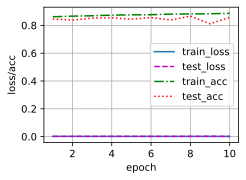

In [19]:
animator = util.Animator(xlabel="epoch", ylabel="loss/acc", legend=["train_loss","test_loss","train_acc","test_acc"])
res_list = []
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(net,loss_function,updater,train_data)
    test_loss, test_acc = get_test_data_loss_acc(net,loss_function,test_data)
    # 测试数据
    animator.add(epoch+1,[train_loss,test_loss,train_acc,test_acc])
    res_list.append([train_loss,test_loss,train_acc,test_acc])

print("epoch:\tloss: train\ttest, acc: train\ttest")
for epoch, res in enumerate(res_list):
    print(f"{epoch+1}\t{res[0]}\t{res[1]}\t{res[2]}\t{res[3]}")

## 预测

从验证集(这里就用测试集)中选取x,y 

利用模型计算得到y_hat, 然后再选取对应的标签

### 将标签（int）转成标签（str）

In [16]:
def labels_int_to_str(labels_int):
    labels_str = ['t-shirt', 'trouser', 'pullover', 'dress',
                   'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [ labels_str[label_int] for label_int in labels_int]

### 绘图

In [17]:
def plot_test_result(x,real,predict,row,column):
    fig,axes = plt.subplots(nrows=row,ncols=column)
    for i in range(row):
        for j in range(column):
            index = i*column+j
            axes[i][j].get_xaxis().set_visible(False)
            axes[i][j].get_yaxis().set_visible(False)
            axes[i][j].set_title(f"{real[index]}\n{predict[index]}")
            axes[i][j].imshow(x[index])

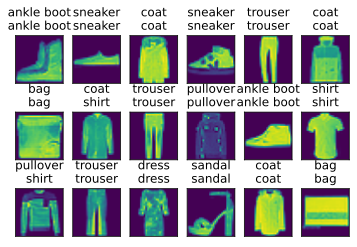

In [20]:
row = 3
column = 6
for x,y in test_data:
    x = x[:row*column,]
    y_hat = net(x.reshape(-1,input_num))
    pred_labels_int = y_hat.max(dim=1).indices
    pred_labels_str = labels_int_to_str(pred_labels_int)
    labels_str = labels_int_to_str(y)
    plot_test_result(x.reshape(row*column,28,28),labels_str,pred_labels_str,row,column)
    
    break